# Digit Recognizer Data Exploration Notebook

In this [Kaggle competition](https://www.kaggle.com/competitions/digit-recognizer/overview) 

>MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

>In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.

## Install necessary packages

We use the requirement.txt file to list all the dependencies and then run pip install for the requirements.

In [1]:
%pip install -r requirements.txt --user --quiet

Note: you may need to restart the kernel to use updated packages.


If this is the first time running this file, restart the kernel.

In [2]:
#%sudo apt-get install graphviz

## Imports

In this section, we import the packages needed in this example.  It is good practice to gather your imports into a single place.  

In [3]:
# Imports
import sys, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile
import seaborn as sns

import tensorflow as tf
from tensorflow import keras, optimizers
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import layers
print("tensorflow version: ", tf.__version__)

from keras_visualizer import visualizer 

from netapp_dataops.k8s import cloneJupyterLab, createJupyterLab, deleteJupyterLab, \
listJupyterLabs, createJupyterLabSnapshot, listJupyterLabSnapshots, restoreJupyterLabSnapshot, \
cloneVolume, createVolume, deleteVolume, listVolumes, createVolumeSnapshot, \
deleteVolumeSnapshot, listVolumeSnapshots, restoreVolumeSnapshot

tensorflow version:  2.12.0


## The Data

The data exists in 4 volumes:
- digit-train
- digit-eval
- digit-test
- digit-prod

There is an additional volume for the model:
- digit-model

These are all mounted at the path represented by DATA_ROOT. 

In [4]:
USER_NAMESPACE = 'kubeflow-user-example-com'

In [5]:
# Designate a root folder for the data
DATA_ROOT = '.\data'
os.makedirs(DATA_ROOT, exist_ok=True)
assert os.path.exists(DATA_ROOT)

In [6]:
# Training data paths
DATA_TRAIN_ROOT = os.path.join(DATA_ROOT,'train')
os.makedirs(DATA_TRAIN_ROOT, exist_ok=True)
assert os.path.exists(DATA_TRAIN_ROOT)
DATA_TRAIN_FILE = os.path.join(DATA_TRAIN_ROOT,'train.csv')
# Testing data paths
DATA_TEST_ROOT = os.path.join(DATA_ROOT,'test')
os.makedirs(DATA_TEST_ROOT, exist_ok=True)
assert os.path.exists(DATA_TEST_ROOT)
DATA_TEST_FILE = os.path.join(DATA_TEST_ROOT,'test.csv')
# Evaluation data paths
DATA_EVAL_ROOT = os.path.join(DATA_ROOT,'eval')
os.makedirs(DATA_EVAL_ROOT, exist_ok=True)
assert os.path.exists(DATA_EVAL_ROOT)
DATA_EVAL_FILE = os.path.join(DATA_EVAL_ROOT,'eval.csv')
# Production data paths
DATA_PROD_ROOT = os.path.join(DATA_ROOT,'prod')
os.makedirs(DATA_PROD_ROOT, exist_ok=True)
assert os.path.exists(DATA_PROD_ROOT)
DATA_PROD_FILE = os.path.join(DATA_PROD_ROOT,'prod.csv')

In [7]:
# Model data paths
MODEL_ROOT = 'model'
DATA_MODEL_ROOT = os.path.join(DATA_ROOT, MODEL_ROOT)
os.makedirs(DATA_MODEL_ROOT, exist_ok=True)
assert os.path.exists(DATA_MODEL_ROOT)

## Clone the data volumes
We will not touch the original volumes but instead will work with cloned volumes only.  

In [ ]:
USER_NAMESPACE = "kubeflow-user-example-com"

In [ ]:
# The source content presistentvolumeclaims names
PVC_TRAIN_SRC = 'train'
PVC_EVAL_SRC = 'eval'
PVC_TEST_SRC = 'test'
PVC_PROD_SRC = 'prod'

In [4]:
# New persistentvolumeclaims names for the clone volumes
PVC_TRAIN_CLONE = 'train-clone' 
PVC_EVAL_CLONE = 'eval-clone'
PVC_TEST_CLONE = 'test-clone'
PVC_PROD_CLONE = 'prod-clone'

In [5]:
# Clone the training volume 
# in the USER_NAMESPACE namespace and create a new persistentvolumeclaim
cloneVolume --source-pvc-name=PVC_TRAIN_SRC --new-pvc-name=PVC_TRAIN_CLONE --namespace=USER_NAMESPACE

SyntaxError: cannot assign to expression (2907983835.py, line 1)

In [ ]:
# Clone the evaluation volume 
# in the USER_NAMESPACE namespace and create a new persistentvolumeclaim
cloneVolume  --source-pvc-name=PVC_EVAL_SRC- -new-pvc-name=PVC_EVAL_CLONE --namespace=USER_NAMESPACE

In [ ]:
# Clone the test volume 
# in the USER_NAMESPACE namespace and create a new persistentvolumeclaim
cloneVolume  --source-pvc-name=PVC_TEST_SRC- -new-pvc-name=PVC_TEST_CLONE --namespace=USER_NAMESPACE

In [ ]:
# Clone the production volume 
# in the USER_NAMESPACE namespace and create a new persistentvolumeclaim
cloneVolume  --source-pvc-name=PVC_PROD_SRC- -new-pvc-name=PVC_PROD_CLONE --namespace=USER_NAMESPACE

## Training Data Preparation

In [8]:
DATA_TRAIN_FILE = os.path.join(DATA_TRAIN_ROOT, 'train.csv')
# Loading dataset into pandas 
TRAIN_DF = pd.read_csv(DATA_TRAIN_FILE)

In [9]:
# View the top 5 rows of the training data
TRAIN_DF.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Initial shape of the training data
TRAIN_DF.shape

(31500, 785)

In [11]:
# Separate out the image data (_X) from the label (_Y) for the train set
TRAIN_X = TRAIN_DF.drop('label', axis=1)
TRAIN_Y = TRAIN_DF.label
# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)... This is needed for the Keras API
TRAIN_X = TRAIN_X.values.reshape(-1,28,28,1)
# Normalize the data
# Each pixel has a value between 0-255. Here we divide by 255, to get values from 0-1
TRAIN_X = TRAIN_X /255.0
TRAIN_X.shape, TRAIN_Y.shape

((31500, 28, 28, 1), (31500,))

## Model Building


In [12]:
# hyper parameters
EPOCHS = 1

In [13]:
#Set random seed for reproducibility and ignore warning messages
tf.random.set_seed(42)
np.random.seed(42)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

In [14]:

# Creating a model using a stack of layers
model = keras.models.Sequential()

# Creating 3 layers of a convolution network
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.MaxPool2D(2, 2))

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPool2D(2, 2))

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPool2D(2, 2))

# Flatting the results
model.add(keras.layers.Flatten())

# Creating output
model.add(keras.layers.Dense(64, activation='relu'))

model.add(keras.layers.Dense(32, activation='relu'))

# Most important
# Output are 10 classes, numbers from 0-9
model.add(keras.layers.Dense(10, activation='softmax')) 

# Show model summary - how it looks
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 64)         0

In [15]:
PNG_MODEL_FILE = os.path.join(DATA_ROOT,'digits-model')
visualizer(model, file_name=PNG_MODEL_FILE, file_format='png', view=False)

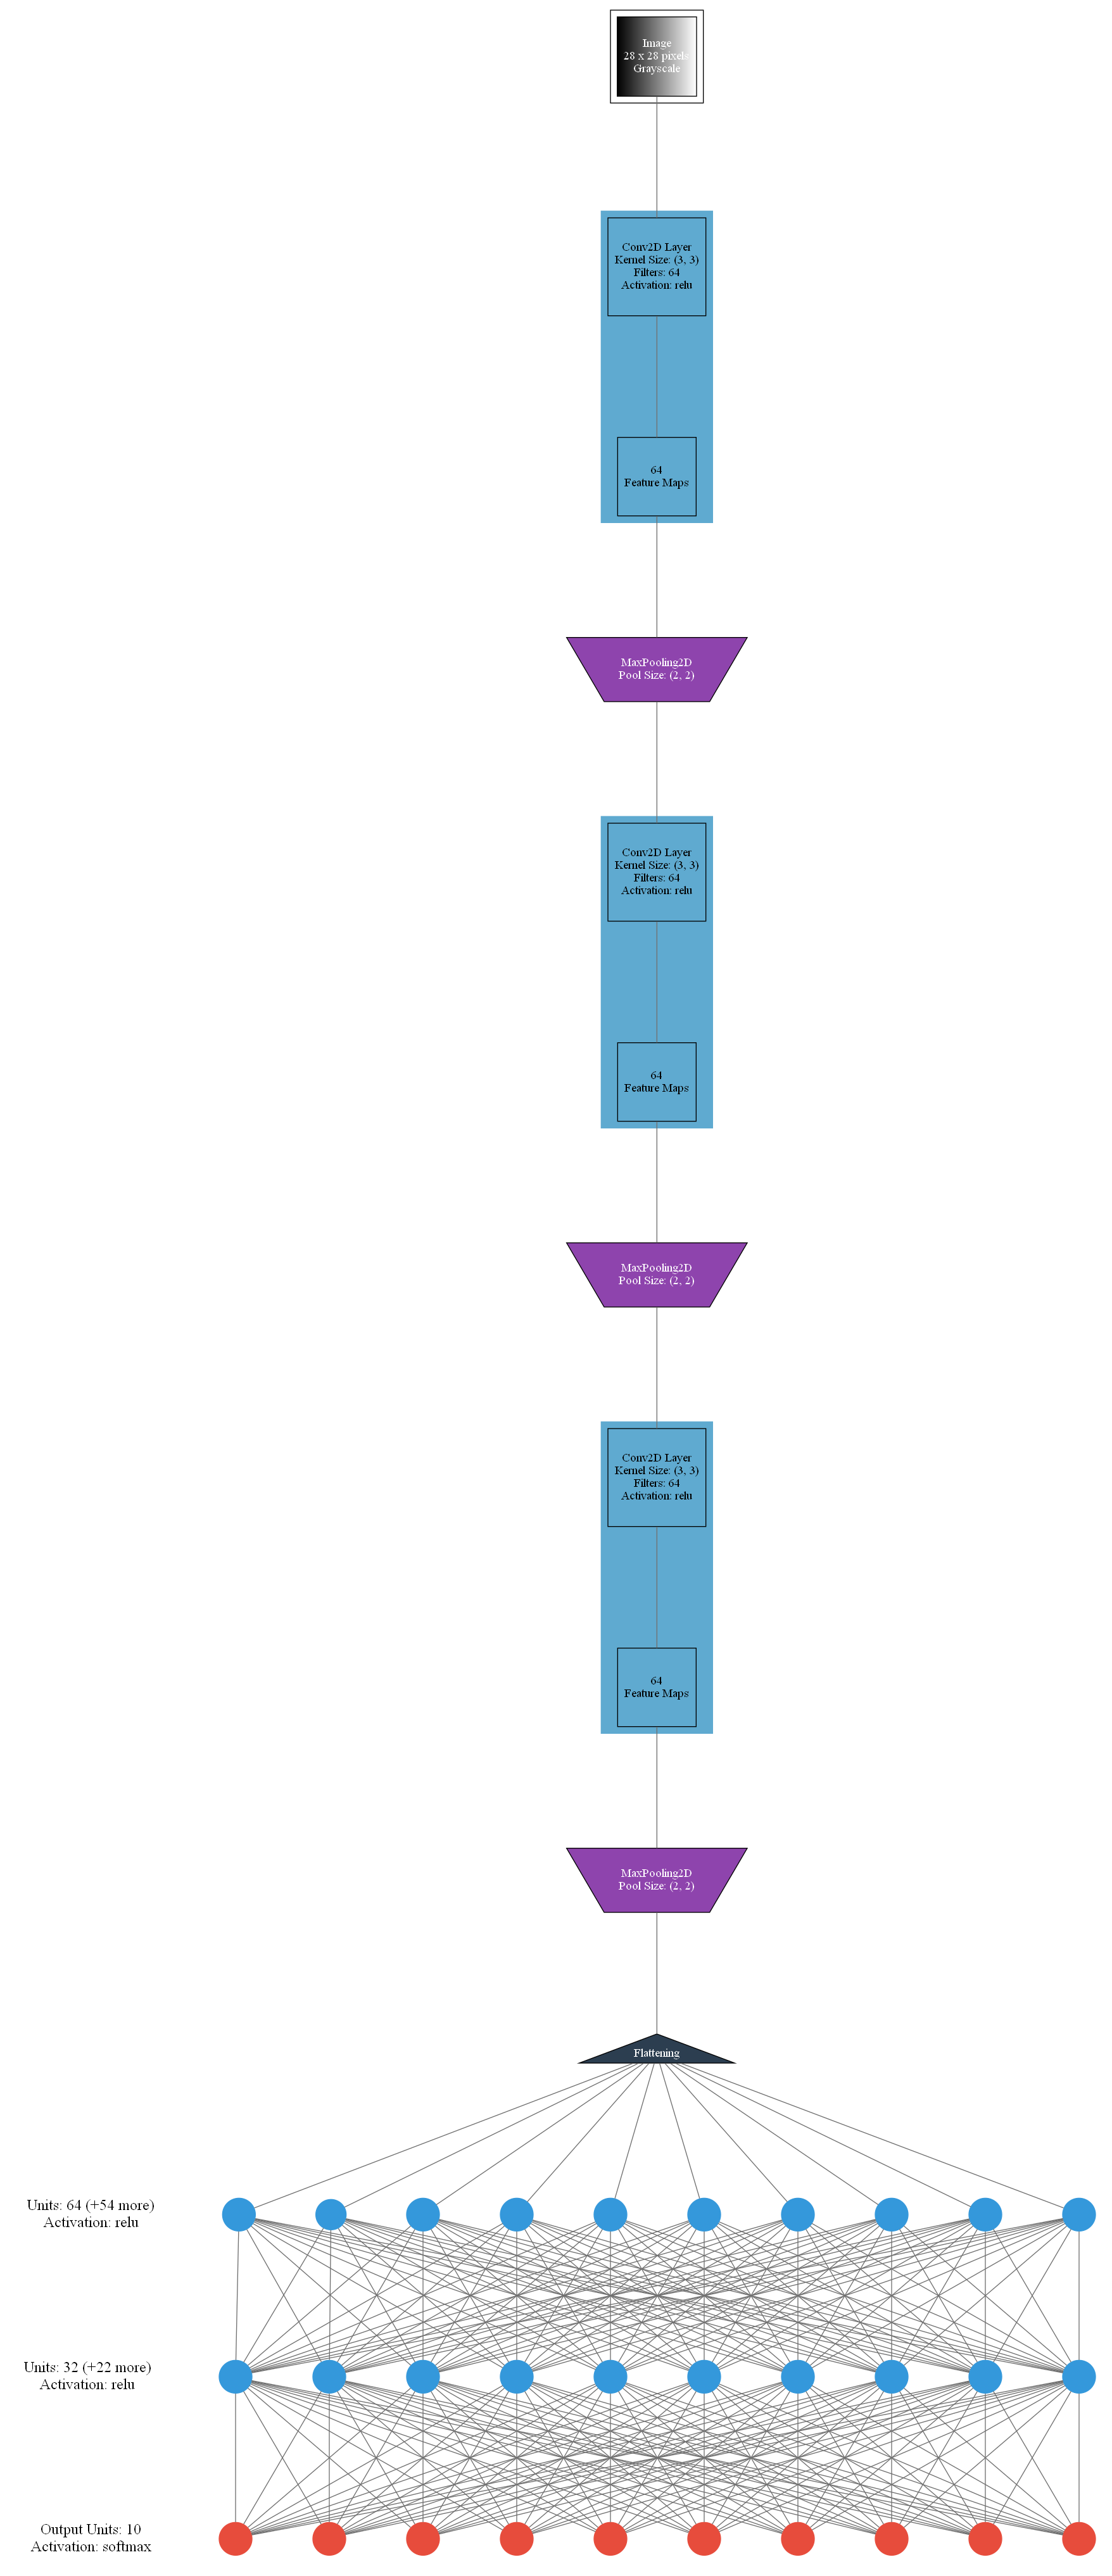

In [16]:
from IPython.display import Image
Image(PNG_MODEL_FILE+ '.png')


In [17]:
# Compile the model - we want to have a multiple outcome
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [18]:
# Fit the model and return the history while training
history = model.fit(
  x=TRAIN_X,
  y=TRAIN_Y,
  epochs=EPOCHS
)

985/985 [==============================] - 94s 94ms/step - loss: 0.3454 - accuracy: 0.8886


In [19]:
# Save the model the model volume
keras.models.save_model(model, DATA_MODEL_ROOT)

INFO:tensorflow:Assets written to: .\data\model\assets


INFO:tensorflow:Assets written to: .\data\model\assets


## Model Access

In [20]:
# Load model if already trained
model = keras.models.load_model(DATA_MODEL_ROOT)

## Model Evaluation

In [21]:
EVAL_DF = pd.read_csv(DATA_EVAL_FILE)

In [22]:
EVAL_DF.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
EVAL_DF.shape

(10500, 785)

In [24]:
# Spilt the training data into so the label is in TRAIN_Y and TRAIN_X doesn't include the label
EVAL_X = EVAL_DF.drop('label', axis=1)
EVAL_Y = EVAL_DF.label

# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
EVAL_X = EVAL_X.values.reshape(-1,28,28,1)


# Normalize the data
# Each pixel has a value between 0-255. Here we divide by 255, to get values from 0-1
EVAL_X = EVAL_X / 255.0

In [25]:
EVAL_X.shape

(10500, 28, 28, 1)

In [30]:
# Test the model against the test dataset
# Returns the loss value & metrics values for the model in test mode.
model_loss, model_accuracy = model.evaluate(x=EVAL_X,y=EVAL_Y, verbose=0)
print("Test_loss: {}, Test_accuracy: {} ".format(model_loss,model_accuracy))

Test_loss: 0.13063044846057892, Test_accuracy: 0.9603809714317322 


329/329 [==============================] - 12s 34ms/step


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Confusion Matrix')]

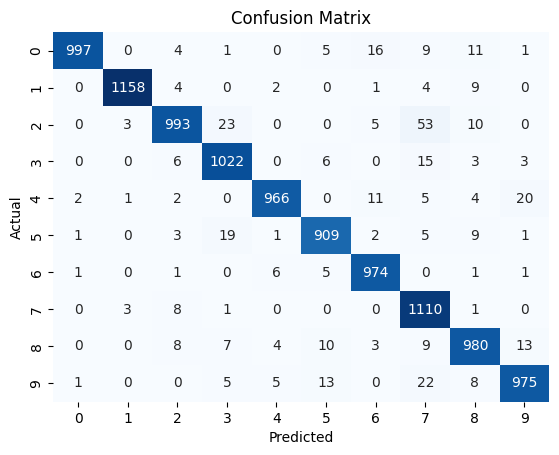

In [34]:
# Confusion Matrix

# Generates output predictions for the input samples.
test_predictions = model.predict(x=EVAL_X)

# Returns the indices of the maximum values along an axis.
test_predictions = np.argmax(test_predictions,axis=1) # the prediction outputs 10 values, we take the index number of the highest value, which is the prediction of the model

# generate confusion matrix
confusion_matrix = tf.math.confusion_matrix(labels=EVAL_Y,predictions=test_predictions)

# plot confusion matrix
h = sns.heatmap(confusion_matrix, fmt='g', cbar=False, annot=True,cmap='Blues')
h.set(xlabel='Predicted', ylabel='Actual', title="Confusion Matrix")